In [1]:
import os
import re
import sys
import json
import codecs
import locale
import logging
import requests
from enum import Enum
import datetime as dt
from typing import Union, Optional, Tuple, List, cast

from matplotlib import pyplot as plt    # type: ignore  
import matplotlib.gridspec as gridspec  # type: ignore 

import pandas as pd
import numpy as np

In [2]:
#----------------------------------------------------------------
# Configurations section
#----------------------------------------------------------------

temp_content_dir = os.path.join(os.sep, 'tmp')
images_path = os.path.join("..","images")

now = dt.datetime.now()
sample_date = now.strftime("%d/%m/%Y")

locale.setlocale(locale.LC_ALL, 'it_IT.UTF-8')

ok_statuses = [200, 201, 202]
data_file_path = os.path.join(os.sep,"Users","ERIZZAG5J","Work","jmeter")
data_file_name = "VAS-manifest-akamai_20220224_154432.jtl"
csv_data_file = os.path.join(data_file_path, data_file_name)

image_file_prefix = "Test-"

class TypeOfOutputChart(Enum):
    PDF = 1
    PNG = 2
    JPG = 3

output_chart_type = TypeOfOutputChart.JPG

In [3]:
#----------------------------------------------------------------
# Import the procedures that download and transform the pdf file
# into a dataframe.
#----------------------------------------------------------------

module_path = os.path.abspath(os.path.join('..','src'))
common_path = os.path.abspath(os.path.join('..','src','common'))
print("{p2} {p1}".format(p1=common_path, p2=module_path))
if module_path not in sys.path:
    sys.path.append(module_path)
    sys.path.append(common_path)

from common.logger_init     import init_logger    
from common.result_value    import ResultValue, ResultOk, ResultKo    
from report.ChartTools      import text_box    
from report.CreateReport    import get_dataframe_from_csv
from report.CreateReport    import get_dataframe_from_csv
from report.CreateReport    import elapsed_chart
from report.CreateReport    import threads_chart
from report.CreateReport    import picture_title_text
from report.CreateReport    import create_label_dict
from report.CreateReport    import get_global_statistics
from report.CreateReport    import statistics_box_text
from report.CreateReport    import elapsed_binned_chart
from report.CreateReport    import elapsed_frequency_chart
from report.CreateReport    import transaction_per_second_chart
from report.CreateReport    import quantiles_box_text
module_path = os.path.abspath(os.path.join('..','src'))

/Users/ERIZZAG5J/repos/JMeter_report/src /Users/ERIZZAG5J/repos/JMeter_report/src/common


In [4]:
df_dict = get_dataframe_from_csv(csv_data_file, ok_codes=ok_statuses)
if df_dict.is_ok() == False:
    assert False, df_dict()

df = df_dict()["df"]
df_errors = df_dict()["errors_df"]
df_binned = df_dict()["binned_elapsed"]

global_stats = get_global_statistics(df=df_dict()["df"], errors_df=df_dict()["errors_df"])
time_limits = [global_stats()["test begin"] - pd.Timedelta(minutes=0.5) 
              ,global_stats()["test end"]   + pd.Timedelta(minutes=0.5)]

labels = create_label_dict(language="en")()


/Users/ERIZZAG5J/repos/JMeter_report/src/report/CreateReport.py:465: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x, rotation=80)
/var/folders/ny/gwc3ss8d6w9bsgvbdll9dw5m0000gq/T/ipykernel_43565/4038740002.py:71: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "papertype" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(os.path.join(images_path,"{prefix}All-CHARTS.{fmt}".format(fmt=output_format, prefix=image_file_prefix))


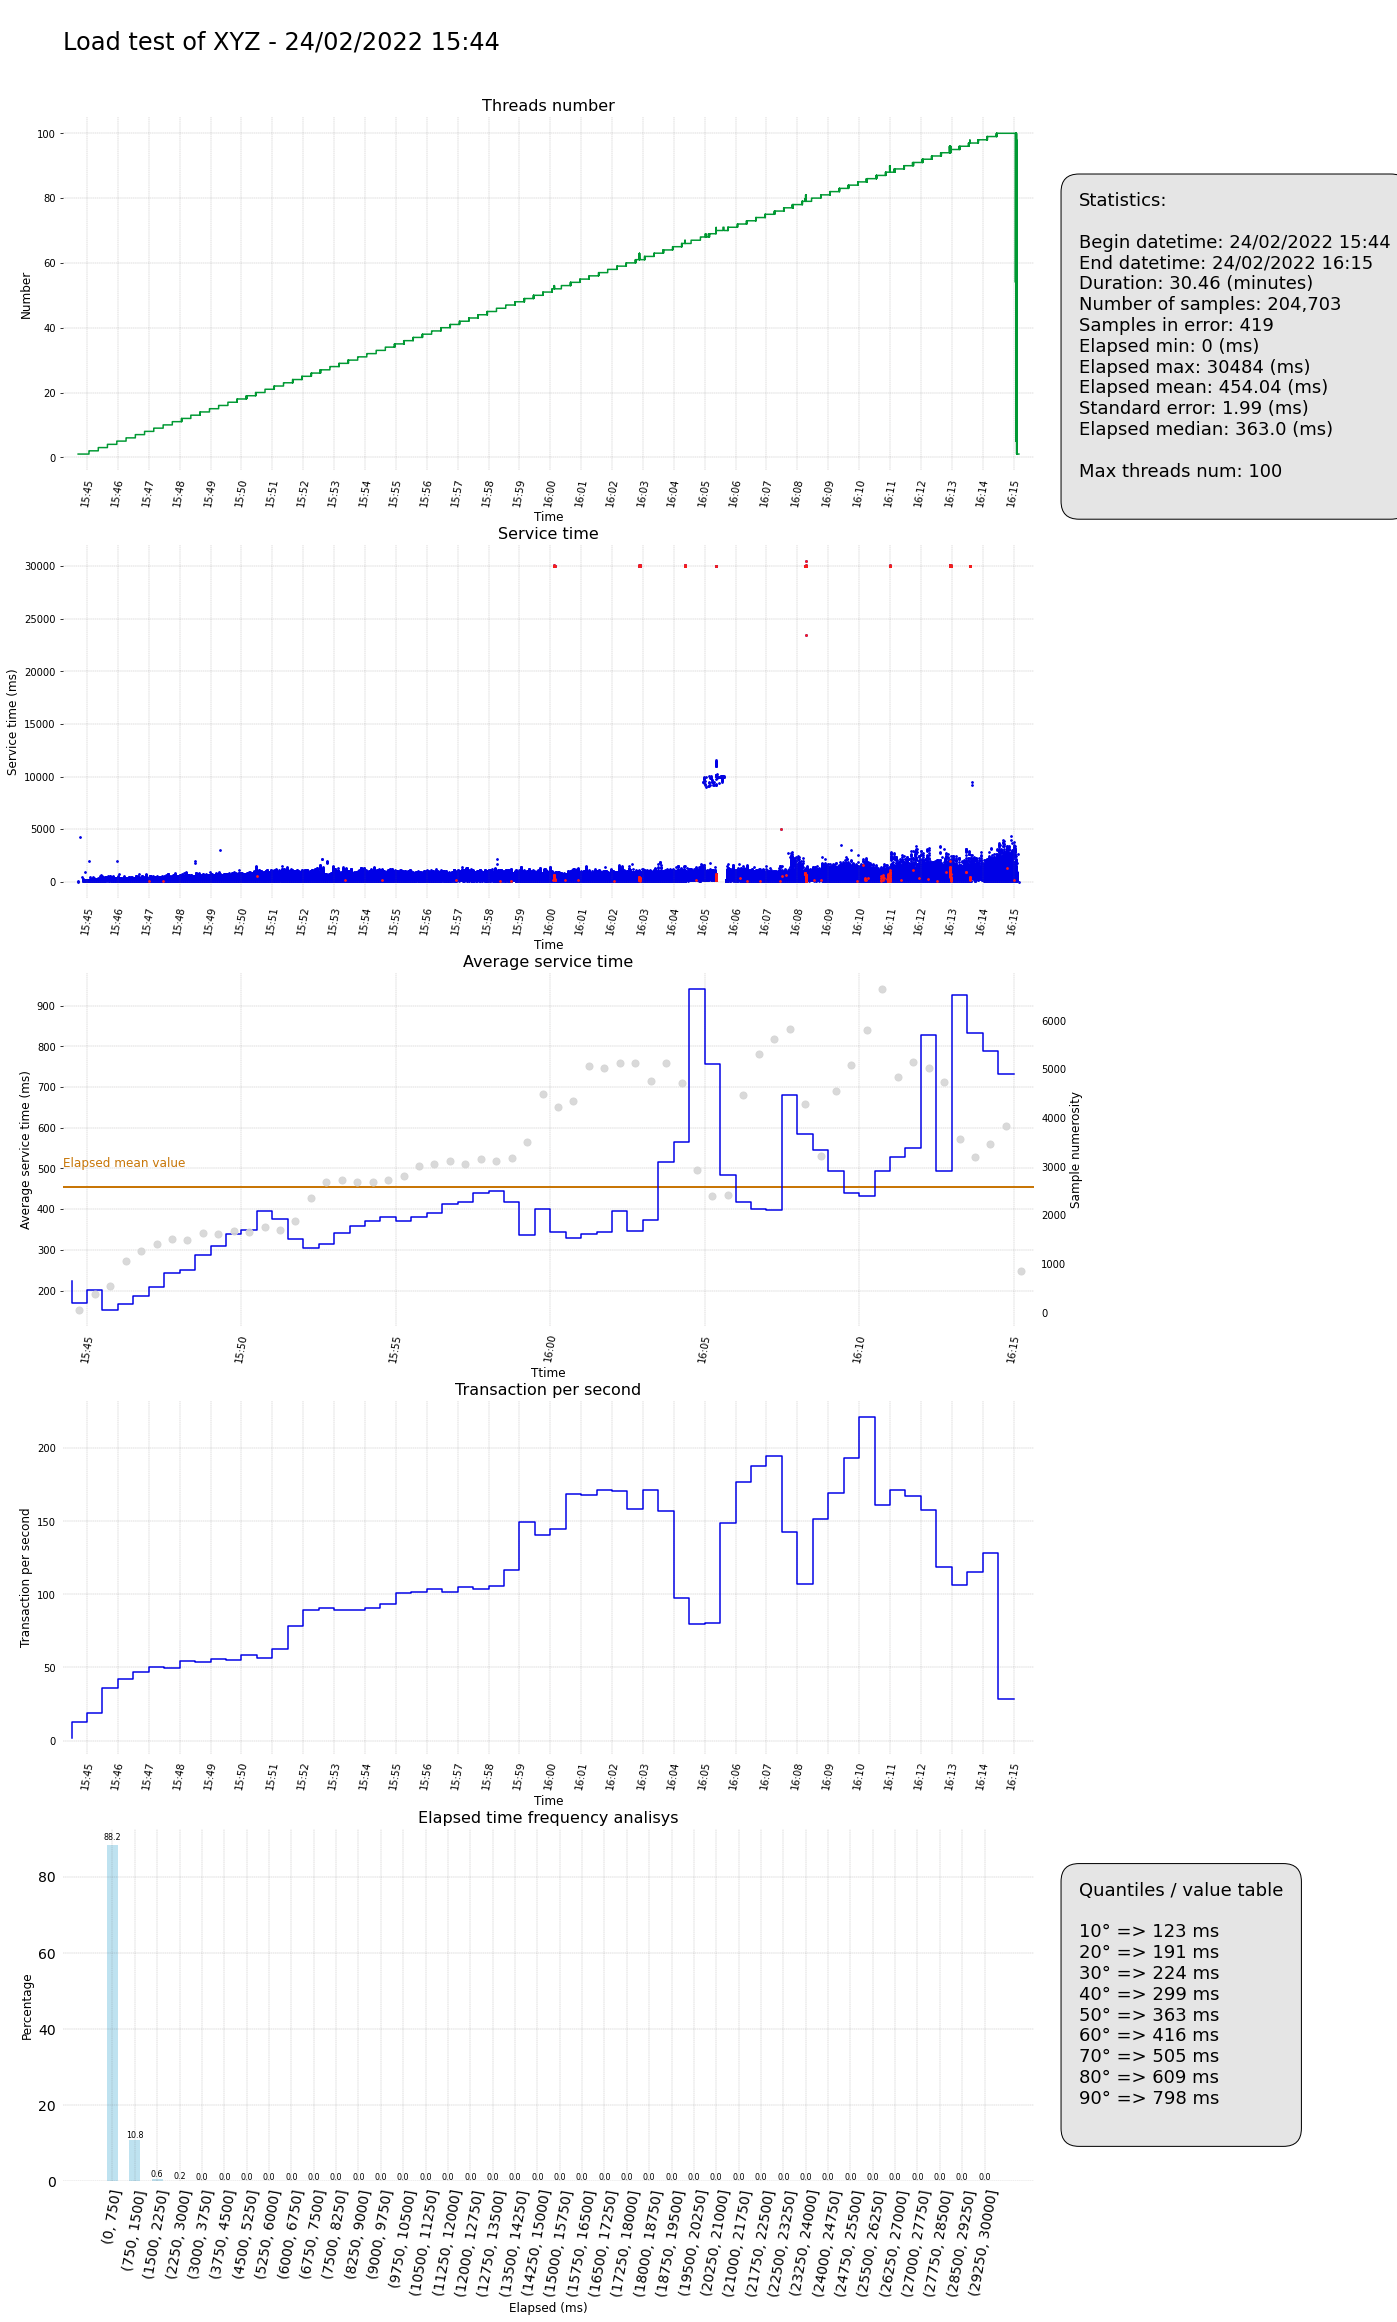

In [5]:
fig0 = plt.figure(figsize=(21, 40)) #, constrained_layout=True)

gs1 = gridspec.GridSpec(6, 2
                       ,figure=fig0
                       ,hspace=0.25
                       ,wspace=0.01 
                       ,height_ratios=[1, 10, 10, 10, 10, 10]
                       ,width_ratios=[10, 2])
ax = []

idx = 0
ax.append(fig0.add_subplot(gs1[0,0]))
text = picture_title_text(labels["picture_title"][0],  global_stats())
if text.is_ok() == True:
    text_box(ax[idx], text(), fontsize=labels["picture_title"][1])
    
idx += 1
ax.append(fig0.add_subplot(gs1[1,0]))
threads_chart(ax=ax[idx], df=df, labels=labels, time_limits=time_limits)

idx += 1
ax.append(fig0.add_subplot(gs1[1, 1]))
stats_txt = statistics_box_text(global_stats(), labels)
if text.is_ok() == True:
    text_box(ax[idx], stats_txt(), fontsize=labels['statistics'][1], y=0.35, colors=["#e5e5e5", "#000000", "#000000"],x=0.2)

idx += 1
ax.append(fig0.add_subplot(gs1[2,0]))
elapsed_chart(ax=ax[idx], df=df, errors_df=df_errors, labels=labels, time_limits=time_limits)

idx += 1
ax.append(fig0.add_subplot(gs1[3,0]))
elapsed_binned_chart(ax[idx]
                    ,binned_df=df_binned
                    ,global_statistics=global_stats()
                    ,labels=labels
                    ,time_limits=time_limits)

idx += 1
ax.append(fig0.add_subplot(gs1[4,0]))
transaction_per_second_chart(ax=ax[idx]
                            ,binned_df=df_binned
                            ,labels=labels
                            ,time_limits=time_limits)

idx += 1
ax.append(fig0.add_subplot(gs1[5,0]))
elapsed_frequency_chart(ax=ax[idx]
                       ,df=df
                       ,global_statistics=global_stats()
                       ,labels=labels)

idx += 1
ax.append(fig0.add_subplot(gs1[5,1]))

text = quantiles_box_text(labels, global_stats()) 
if text.is_ok() == True:
    text_box(ax[idx], text(), fontsize=labels['quantiles'][1], colors=["#e5e5e5", "#000000", "#000000"], x=0.2, y=0.5)    

if output_chart_type == TypeOfOutputChart.PDF:
    output_format = "pdf"
    paper_type = 'a4'
    plt.savefig(os.path.join(images_path,"{prefix}All-CHARTS.{fmt}".format(fmt=output_format, prefix=image_file_prefix))
               ,format=output_format
               ,papertype=paper_type 
               ,bbox_inches='tight'
               ,pad_inches=0.5)
elif output_chart_type == TypeOfOutputChart.JPG:
    output_format = "jpg"
    paper_type = 'a4'
    plt.savefig(os.path.join(images_path,"{prefix}All-CHARTS.{fmt}".format(fmt=output_format, prefix=image_file_prefix))
               ,format=output_format
               ,papertype=paper_type 
               ,bbox_inches='tight'
               ,pad_inches=0.5)    
else:
    output_format = "png"
    plt.savefig(os.path.join(images_path,"{prefix}All-CHARTS.{fmt}".format(fmt=output_format, prefix=image_file_prefix))
               ,format=output_format
               ,bbox_inches='tight'
               ,pad_inches=0.5)


In [6]:
df.shape

(204703, 6)

In [7]:
bin_step = 250

for idx in [0, 1, 2]:
    cut_bins = list(range(0, global_stats()["max elapsed"], bin_step))

    df['elapsed binned'] = pd.cut(df['elapsed'], bins=cut_bins, right=True)
    frequencies = df['elapsed binned'].value_counts(sort=False)

    if frequencies[0] <= 10:
        break
    else:
        bin_step = int(bin_step * 1.3)
        
        

In [8]:
frequencies.shape

(72,)